# Imports

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Work with Data

## Read original data

In [159]:
read_df = pd.read_csv("japanese_universities.csv")
# print(read_df.to_string())

## DataFrame with specific columns

- faculty_count: the number of faculties in universities.
- department_count: the number of departments in universities.
- has_grad: the availability of the graduate school. True or False.
- has_remote: the availability of the remote school. True or False.
- review_rating: the review rating of universities.
- review_count: the number of reviews of universities.
- difficulty_SD: the standard deviation measurement of universities' difficulty.
- difficulty_rank: the rank of universities' difficulty. The highest to lowest ranking order is - [S,A,B,C,D,E,F]


In [160]:
df = read_df[['faculty_count', 'department_count', 'has_remote', 'has_grad', 
              'review_rating', 'review_count', 'difficulty_SD', 'difficulty_rank']]
# print(df.to_string())

# Preprocessing

## Missing Data

In [161]:
missing_percent = df.isnull().mean() * 100
print(missing_percent)

faculty_count       0.000000
department_count    0.000000
has_remote          0.000000
has_grad            0.000000
review_rating       1.845018
review_count        1.845018
difficulty_SD       7.257073
difficulty_rank     7.257073
dtype: float64


## Data frame with no missing data in difficulty_rank

In [162]:
train_df = df.dropna(subset=['difficulty_rank'])
train_df = train_df.dropna(subset=['review_rating'])
train_df = train_df.dropna(subset=['review_count'])

missing_percent = train_df.isnull().mean() * 100
print(missing_percent)

# print("\nOczyszczony DataFrame:")
# print(train_df.to_string())

faculty_count       0.0
department_count    0.0
has_remote          0.0
has_grad            0.0
review_rating       0.0
review_count        0.0
difficulty_SD       0.0
difficulty_rank     0.0
dtype: float64


# Preparing data after preprocessing

In [163]:
Y = train_df["difficulty_rank"]
X = train_df.drop(columns=["difficulty_rank"])

## one-hot

In [164]:
X = pd.get_dummies(X, drop_first=True)

## Label Encoding

In [165]:
le = LabelEncoder()
y_encoded = le.fit_transform(Y)

## Split train_data = 80%, test_data = 20%

In [166]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

## Standardization

In [167]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Conversion to tensor

In [168]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

## DataLoader

In [169]:
train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=16, shuffle=False)

# Model

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, num_classes)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)  # logits
        return x

model = MLP(input_dim=X_train.shape[1], num_classes=len(le.classes_))

# loss + optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Trening

In [171]:
epochs = 2000
patience, counter = 5, 0
best_loss, best_state = float("inf"), None

for epoch in range(epochs):
    # --- train ---
    model.train()
    for xb, yb in train_dl:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()

    # --- val ---
    model.eval()
    with torch.no_grad():
        val_loss = criterion(model(X_test_t), y_test_t).item()

    # --- early stopping ---
    if val_loss < best_loss:
        best_loss, best_state, counter = val_loss, model.state_dict(), 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Stop at epoch {epoch+1}")
            break

    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} | val loss: {val_loss:.4f}")

# wczytanie najlepszego modelu
model.load_state_dict(best_state)


Epoch 1/2000 | val loss: 1.5799
Epoch 10/2000 | val loss: 1.0060
Epoch 20/2000 | val loss: 0.5458
Epoch 30/2000 | val loss: 0.3550
Epoch 40/2000 | val loss: 0.2902
Epoch 50/2000 | val loss: 0.2413
Epoch 60/2000 | val loss: 0.2333
Stop at epoch 62


<All keys matched successfully>

# Evaluation

Classification report:
               precision    recall  f1-score   support

           A       0.67      0.80      0.73         5
           B       0.86      0.75      0.80         8
           C       0.96      1.00      0.98        24
           D       1.00      0.83      0.91        18
           E       0.91      1.00      0.95        30
           F       1.00      0.98      0.99        63
           S       0.00      0.00      0.00         2

    accuracy                           0.94       150
   macro avg       0.77      0.77      0.77       150
weighted avg       0.94      0.94      0.94       150



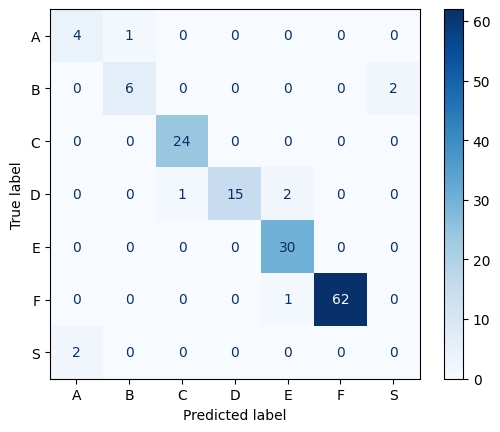

In [172]:
model.eval()
with torch.no_grad():
    logits = model(X_test_t)
    y_pred = torch.argmax(logits, dim=1).numpy()

print("Classification report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# macierz konfuzji
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues")
plt.show()

# Summary of results

In [173]:
results = pd.DataFrame({
    "True": le.inverse_transform(y_test),
    "Pred": le.inverse_transform(y_pred)
})

# ogólna liczba poprawnych przewidywań
correct = (results["True"] == results["Pred"]).sum()
total = len(results)
accuracy = correct / total

# dokładność per klasa
accuracy_per_class = results.groupby("True").apply(lambda x: (x["True"] == x["Pred"]).mean()) * 100

print(f"Ogólna dokładność: {accuracy:.2%} \n")
print("Dokładność per klasa:")
print(accuracy_per_class)

print("\nPorównanie True vs Pred (pierwsze 20 próbek):")
display(results.head(30))

Ogólna dokładność: 94.00% 

Dokładność per klasa:
True
A     80.000000
B     75.000000
C    100.000000
D     83.333333
E    100.000000
F     98.412698
S      0.000000
dtype: float64

Porównanie True vs Pred (pierwsze 20 próbek):


C:\Users\oskar\AppData\Local\Temp\ipykernel_11144\798066821.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_per_class = results.groupby("True").apply(lambda x: (x["True"] == x["Pred"]).mean()) * 100


,True,Pred
0,F,F
1,D,E
2,C,C
3,D,D
4,D,D
5,E,E
6,B,B
7,F,F
8,F,F
9,F,F
